In [3]:
!pip install catboost
!pip install optuna

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("bank.csv")
target_name = "deposit"

In [5]:
target_name = "deposit"

In [6]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


Классы более менее сбалансированы.

In [7]:
df[target_name].value_counts()

,count
deposit,
no,5873
yes,5289


In [8]:
y = df[target_name]
X = df.drop(columns=[target_name])

In [9]:
from sklearn.model_selection import train_test_split
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size = 0.15, shuffle=True)
X_train, X_valid, y_train, y_valid = train_test_split(X_1, y_1, test_size=0.15)

Default catboost:

In [10]:
from catboost import CatBoostClassifier
default_model = CatBoostClassifier(iterations = 1000, task_type="GPU")

In [11]:
cat_features = df.select_dtypes('object').columns
categorical_features_indices = np.where(X_train.dtypes != float)[0]

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    roc_curve,
)
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, pos_label='yes'):
    """
    Вычисляет метрики и строит график AUC для модели CatBoostClassifier.

    Параметры:
        model: Обученная модель CatBoostClassifier.
        X_test: Тестовые данные (признаки).
        y_test: Истинные значения целевой переменной.

    Возвращает:
        Словарь с метриками: accuracy, f1_score, roc_auc, precision, recall.
    """
    # Предсказание вероятностей и классов
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Вероятности для положительного класса
    y_pred = model.predict(X_test)  # Предсказанные классы

    # Вычисление метрик
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label=pos_label)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, pos_label=pos_label)
    recall = recall_score(y_test, y_pred, pos_label=pos_label)
    # Возвращение метрик
    return {
        "accuracy": accuracy,
        "f1_score": f1,
        "roc_auc": roc_auc,
        "precision": precision,
        "recall": recall,
    }

In [13]:
default_model.fit(X_train,
          y_train,
          verbose=False, cat_features = categorical_features_indices)

In [14]:
accuracy = default_model.score(X_test, y_test)
accuracy

0.8370149253731344

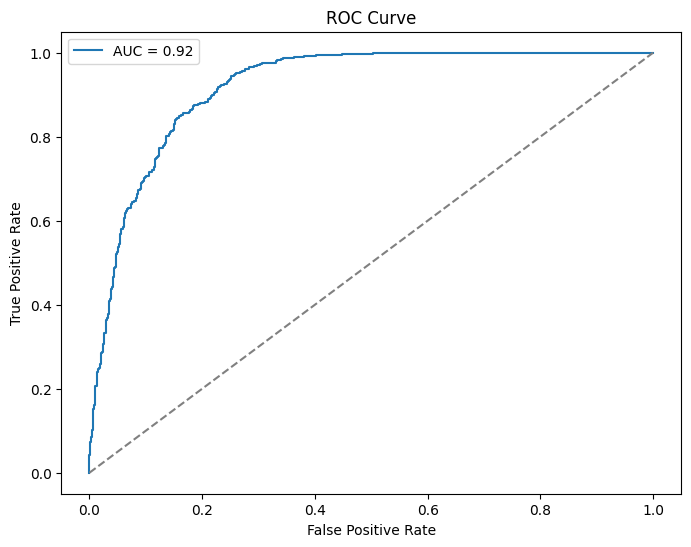

{'accuracy': 0.8370149253731344,
 'f1_score': 0.8370149253731344,
 'roc_auc': 0.9192701560235851,
 'precision': 0.7984054669703873,
 'recall': 0.8795483061480552}

In [15]:
evaluate_model(default_model, X_test, y_test.values)

In [16]:
model = CatBoostClassifier(
        iterations=1000,
        depth=6,
        learning_rate=0.005,
        loss_function='Logloss',
        cat_features = categorical_features_indices,
        task_type="GPU",
        bootstrap_type="Bayesian",
        grow_policy="Lossguide",
        random_strength=2,
        bagging_temperature=1,
        l2_leaf_reg=0.01,
        verbose=250
    )
model.fit(X_train, y_train)

0:	learn: 0.6901833	total: 20.3ms	remaining: 20.3s
250:	learn: 0.4309201	total: 11.5s	remaining: 34.2s
500:	learn: 0.3882708	total: 30.7s	remaining: 30.6s
750:	learn: 0.3690607	total: 36.5s	remaining: 12.1s
999:	learn: 0.3571151	total: 51.9s	remaining: 0us


In [17]:
model.score(X_test, y_test)

0.8250746268656717

In [18]:
model = CatBoostClassifier(learning_rate= 0.03454190018372963, objective='Logloss', colsample_bylevel = 0.32757765370471664, depth= 7, boosting_type= 'Ordered', bootstrap_type= 'Bernoulli', cat_features = categorical_features_indices)

In [19]:
model.fit(X_train, y_train, verbose=0)

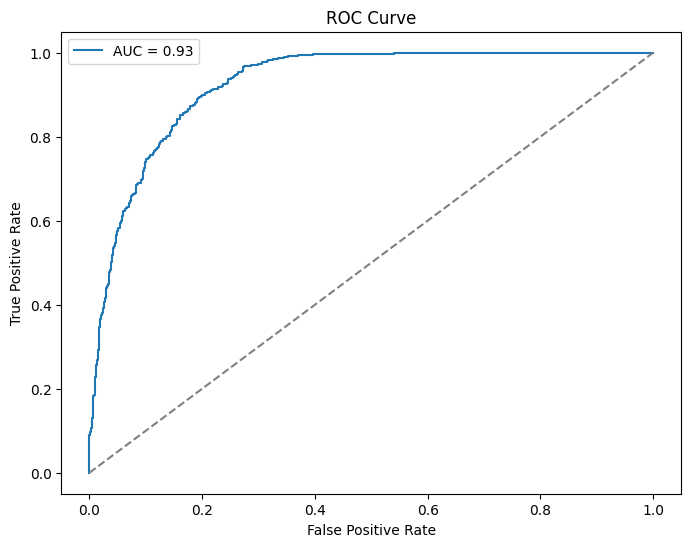

{'accuracy': 0.8477611940298507,
 'f1_score': 0.8483045806067817,
 'roc_auc': 0.9254779454846334,
 'precision': 0.8065610859728507,
 'recall': 0.8946047678795483}

In [20]:
evaluate_model(model, X_test, y_test.values)


In [21]:
importance = model.get_feature_importance()


In [24]:
from sklearn.metrics import accuracy_score
import optuna
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)
y_test_encoded = label_encoder.transform(y_test)
models = []

def objective(trial):
    params = {
        #'iterations' : trial.suggest_int('iterations', 750, 1500, step=250),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.04),
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        #"grow_policy": trial.suggest_categorical("grow_policy", ['SymmetricTree', 'Lossguide']),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.2,0.7),
        "max_depth": trial.suggest_int("depth", 1, 9),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
    }
    model = CatBoostClassifier(**params, verbose=0, cat_features = categorical_features_indices)
    model.fit(X_train, y_train_encoded)
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    y_pred = model.predict(X_valid)
    return roc_auc_score(y_valid, y_pred_proba)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Лучшие параметры:", study.best_params)
print("Лучшее значение метрики:", study.best_value)

[I 2025-03-05 09:28:43,480] A new study created in memory with name: no-name-c8c4fca1-08bd-4def-97ba-1c1436e83ae0
[W 2025-03-05 09:28:47,651] Trial 0 failed with parameters: {'learning_rate': 0.005038290496243106, 'objective': 'Logloss', 'colsample_bylevel': 0.23398990731843378, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-24-2a21364a3e0d>", line 25, in objective
    model.fit(X_train, y_train_encoded)
  File "/usr/local/lib/python3.11/dist-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/usr/local/lib/python3.11/dist-packages/catboost/core

KeyboardInterrupt: 

In [117]:
df2 = pd.read_csv("known_behaviors2.csv")
target_name_1 = "Mortgage"
target_name_2 = "Pension"
target_name_3 = "Savings"
y_m = df2[target_name_1]
y_p = df2[target_name_2]
y_s = df2[target_name_3]
X = df2.drop(columns=[target_name_1, target_name_2, target_name_3])
from sklearn.model_selection import train_test_split
X_1, X_test_m, y_1, y_test_m = train_test_split(X, y_m, test_size = 0.15, shuffle=True)
X_train_m, X_valid_m, y_train_m, y_valid_m = train_test_split(X_1, y_1, test_size=0.15)
X_1, X_test_p, y_1, y_test_p = train_test_split(X, y_p, test_size = 0.15, shuffle=True)
X_train_p, X_valid_p, y_train_p, y_valid_p = train_test_split(X_1, y_1, test_size=0.15)
X_1, X_test_s, y_1, y_test_s = train_test_split(X, y_s, test_size = 0.15, shuffle=True)
X_train_s, X_valid_s, y_train_s, y_valid_s = train_test_split(X_1, y_1, test_size=0.15)

In [32]:
data_mean = X_train_m.mean(axis=0)
data_std = X_train_m.std(axis=0)

X_train_m = (X_train_m - data_mean) / data_std
X_test_m = (X_test_m - data_mean) / data_std
X_valid_m = (X_valid_m - data_mean) / data_std

In [59]:
print("Default catboost for mortgage ")
default_model_m = CatBoostClassifier(iterations=1000,verbose=0)
default_model_m.fit(X_train_m,
          y_train_m,
          verbose=False)
evaluate_model(default_model_m,X_test_m, y_test_m, pos_label=1)

Default catboost for mortgage 


{'accuracy': 0.9153567110036276,
 'f1_score': 0.7188755020080321,
 'roc_auc': 0.9551646740484117,
 'precision': 0.7276422764227642,
 'recall': 0.7103174603174603}

In [60]:
print("Default catboost for pension ")
default_model_p = CatBoostClassifier(iterations=1000,verbose=0)
default_model_p.fit(X_train_p,
          y_train_p,
          verbose=False)
evaluate_model(default_model_p,X_test_p, y_test_p, pos_label=1)

Default catboost for pension 


{'accuracy': 0.7593712212817413,
 'f1_score': 0.22868217054263565,
 'roc_auc': 0.7265221113635615,
 'precision': 0.44029850746268656,
 'recall': 0.1544502617801047}

In [61]:
print("Default catboost for savings")
default_model_s = CatBoostClassifier(iterations=1000,verbose=0)
default_model_s.fit(X_train_s,
          y_train_s,
          verbose=False)
evaluate_model(default_model_s,X_test_s, y_test_s, pos_label=1)

Default catboost for savings


{'accuracy': 0.6354292623941958,
 'f1_score': 0.44321329639889195,
 'roc_auc': 0.6579177131361598,
 'precision': 0.5161290322580645,
 'recall': 0.3883495145631068}

In [127]:
def optimizers(X_train, y_train, X_valid, y_valid, n_trials=10):
  def objective(trial):
    params = {
        'iterations' : trial.suggest_int('iterations', 500, 1500, step=250),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.04),
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "l2_leaf_reg" : trial.suggest_float('l2_leaf_reg', 1, 10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.2,0.7),
        "max_depth": trial.suggest_int("depth", 1, 8),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
    }
    model = CatBoostClassifier(**params, verbose=0)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    y_pred = model.predict(X_valid)
    return roc_auc_score(y_valid, y_pred_proba)

  study = optuna.create_study(direction='maximize')
  study.optimize(objective, n_trials=n_trials)
  return study.best_params

In [71]:
best_m = optimizers(X_train_m, y_train_m, X_valid_m, y_valid_m, n_trials = 30)

[I 2025-03-05 10:40:21,521] A new study created in memory with name: no-name-1087e953-a729-41eb-8d59-4565fbd4fe50
[I 2025-03-05 10:40:23,799] Trial 0 finished with value: 0.9476708074534161 and parameters: {'iterations': 1000, 'learning_rate': 0.011933261323887324, 'objective': 'Logloss', 'l2_leaf_reg': 9.623646735405744, 'colsample_bylevel': 0.21594288246748095, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.9476708074534161.
[I 2025-03-05 10:40:26,343] Trial 1 finished with value: 0.947232839624144 and parameters: {'iterations': 1250, 'learning_rate': 0.024902696822830188, 'objective': 'CrossEntropy', 'l2_leaf_reg': 6.568450206882555, 'colsample_bylevel': 0.6164868279021363, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.9476708074534161.
[I 2025-03-05 10:40:37,502] Trial 2 finished with value: 0.9482720178372352 and parameters: {'iterations': 1250, 'learning_rate': 0.03388496610954805,

In [120]:
y_test_p.value_counts()

,count
Pension,
0,1288
1,366


In [121]:
y_valid_p.value_counts()

,count
Pension,
0,1080
1,326


In [128]:
best_p = optimizers(X_train_p, y_train_p, X_test_p, y_test_p, n_trials = 30)

[I 2025-03-05 11:44:19,761] A new study created in memory with name: no-name-d648c692-6379-416a-a6e8-617224908eec
[I 2025-03-05 11:44:30,119] Trial 0 finished with value: 0.7594992023894376 and parameters: {'iterations': 750, 'learning_rate': 0.02137099170073409, 'objective': 'Logloss', 'l2_leaf_reg': 8.228703793443865, 'colsample_bylevel': 0.46562329209873066, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.7594992023894376.
[I 2025-03-05 11:45:00,587] Trial 1 finished with value: 0.7526473882496691 and parameters: {'iterations': 1250, 'learning_rate': 0.02610167139647828, 'objective': 'CrossEntropy', 'l2_leaf_reg': 4.976363222550034, 'colsample_bylevel': 0.551145212043326, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.7594992023894376.
[I 2025-03-05 11:45:14,157] Trial 2 finished with value: 0.7598364898347079 and parameters: {'iterations': 1250, 'learning_rate': 0.00884364610471131, 'ob

In [73]:
best_s = optimizers(X_train_s, y_train_s, X_valid_s, y_valid_s, n_trials = 30)

[I 2025-03-05 10:51:20,428] A new study created in memory with name: no-name-896eeaa1-f676-48e7-973c-2163e5e6bd98
[I 2025-03-05 10:51:32,293] Trial 0 finished with value: 0.6654037679927648 and parameters: {'iterations': 1000, 'learning_rate': 0.016240738960004057, 'objective': 'Logloss', 'l2_leaf_reg': 7.393296231961553, 'colsample_bylevel': 0.490113321619472, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.6654037679927648.
[I 2025-03-05 10:51:36,318] Trial 1 finished with value: 0.6505344709228205 and parameters: {'iterations': 1500, 'learning_rate': 0.039864577822472484, 'objective': 'Logloss', 'l2_leaf_reg': 5.065206575262516, 'colsample_bylevel': 0.6902687046141593, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.6654037679927648.
[I 2025-03-05 10:51:50,594] Trial 2 finished with value: 0.6566299456267094 and parameters: {'iterations': 1500, 'learning_rate': 0.03666184053781749, 'objecti

In [76]:
best_m

{'iterations': 1250,
 'learning_rate': 0.02790523555920745,
 'objective': 'Logloss',
 'l2_leaf_reg': 1.1475357950152565,
 'colsample_bylevel': 0.2047198259743157,
 'depth': 4,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bernoulli'}

In [78]:
best_model_m = CatBoostClassifier(**best_m, verbose=250)
best_model_m.fit(X_train_m,y_train_m)
evaluate_model(best_model_m, X_test_m, y_test_m, pos_label=1)

0:	learn: 0.6421421	total: 10.4ms	remaining: 13s
250:	learn: 0.2002422	total: 2.31s	remaining: 9.21s
500:	learn: 0.1876355	total: 5.39s	remaining: 8.06s
750:	learn: 0.1792909	total: 8.37s	remaining: 5.56s
1000:	learn: 0.1726325	total: 12.2s	remaining: 3.03s
1249:	learn: 0.1672533	total: 17.2s	remaining: 0us


{'accuracy': 0.9135429262394196,
 'f1_score': 0.7122736418511066,
 'roc_auc': 0.955841145302629,
 'precision': 0.7224489795918367,
 'recall': 0.7023809523809523}

In [129]:
best_p

{'iterations': 750,
 'learning_rate': 0.001100830493204745,
 'objective': 'Logloss',
 'l2_leaf_reg': 2.125304333612128,
 'colsample_bylevel': 0.3660545738113444,
 'depth': 1,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli'}

In [86]:
ss = {'iterations': 1000, 'learning_rate': 0.032592993382736184, 'objective': 'Logloss', 'l2_leaf_reg': 4.55792508644508, 'colsample_bylevel': 0.348484013137108, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}

In [99]:
best_p['iterations'] = 200
best_p

{'iterations': 200,
 'learning_rate': 0.005350032144881398,
 'objective': 'CrossEntropy',
 'l2_leaf_reg': 7.634448191037505,
 'colsample_bylevel': 0.4309194890802742,
 'depth': 1,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'MVS'}

In [130]:
best_model_p = CatBoostClassifier(**best_p, verbose=250)
best_model_p.fit(X_train_p, y_train_p)
evaluate_model(best_model_p, X_test_p, y_test_p, pos_label=1)

0:	learn: 0.6925359	total: 2.37ms	remaining: 1.77s
250:	learn: 0.5869776	total: 328ms	remaining: 651ms
500:	learn: 0.5291530	total: 644ms	remaining: 320ms
749:	learn: 0.4961130	total: 957ms	remaining: 0us


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.7787182587666264,
 'f1_score': 0.0,
 'roc_auc': 0.7650018667481248,
 'precision': 0.0,
 'recall': 0.0}

In [108]:
y_valid_p.value_counts()

,count
Pension,
0,1132
1,274


In [83]:
best_s

{'iterations': 1250,
 'learning_rate': 0.0016209076557410118,
 'objective': 'CrossEntropy',
 'l2_leaf_reg': 9.050483420606026,
 'colsample_bylevel': 0.23957529661769178,
 'depth': 9,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli'}

In [81]:
best_model_s = CatBoostClassifier(**best_s, verbose=250)
best_model_s.fit(X_train_s,y_train_s)
evaluate_model(best_model_s, X_test_s, y_test_s, pos_label=1)

0:	learn: 0.6928451	total: 2.85ms	remaining: 3.56s
250:	learn: 0.6458099	total: 1.18s	remaining: 4.71s
500:	learn: 0.6224636	total: 2.38s	remaining: 3.56s
750:	learn: 0.6090222	total: 3.54s	remaining: 2.35s
1000:	learn: 0.6001225	total: 5.02s	remaining: 1.25s
1249:	learn: 0.5931849	total: 7.02s	remaining: 0us


{'accuracy': 0.6221281741233373,
 'f1_score': 0.410933081998115,
 'roc_auc': 0.6643699004135897,
 'precision': 0.49209932279909707,
 'recall': 0.35275080906148865}